In [1]:
import tensorflow as tf
import os
import numpy as np
from osgeo import gdal, osr
import cv2
import matplotlib.pyplot as plt

In [2]:
def input_pipeline(filename, batch_size, is_shuffle=True, is_train=True, is_repeat=True):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([400*400*4], dtype=tf.int64),
        'label': tf.io.FixedLenFeature([400*400*1], dtype=tf.int64),
    }

    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(feature_dict['image_raw'], [400, 400, 4])
        image = tf.cast(image, tf.float32)

        image = image/10000

        label = tf.reshape(feature_dict['label'], [400, 400, 1])
        label = tf.cast(label, tf.float32)

        image_label = tf.concat([image, label], axis=-1)
        if is_train:
            image_label = tf.image.rot90(image_label, tf.random.uniform([], 0, 5, dtype=tf.int32))
            image_label = tf.image.random_flip_left_right(image_label)
            image_label = tf.image.random_flip_up_down(image_label)

        image = image_label[:, :, :4]
        label = image_label[:, :, -1]

        label = tf.cast(label, tf.int32)

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    if is_repeat:
        dataset = dataset.repeat()
    dataset = dataset.map(_parse_function)
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    batch = dataset.batch(batch_size=batch_size)
    return batch

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Lambda, Conv2D, Conv2DTranspose, Activation, Reshape, concatenate, Concatenate, BatchNormalization, ZeroPadding2D


def Upsample(tensor, size):
    '''Bilinear upsampling using Keras Lambda layer'''
    return Lambda(lambda x: tf.image.resize(x, size))(tensor)


def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)
    # dims = [0, 24, 24]

    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y


def DeepLabV3Plus(img_height=224, img_width=224, nclasses=14):
    print('*** Building DeepLabv3Plus Network ***')

    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(
        img_height, img_width, 4), weights=None, include_top=False)

    image_features = base_model.get_layer('conv4_block6_2_relu').output
    x_a = ASPP(image_features)
    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])

    x_b = base_model.get_layer('conv2_block3_2_relu').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same',
                 kernel_initializer='he_normal', name='low_level_projection', use_bias=False)(x_b)
    x_b = BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = Activation('relu', name='low_level_activation')(x_b)

    x = concatenate([x_a, x_b], name='decoder_concat')

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_1', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_1')(x)
    x = Activation('relu', name='activation_decoder_1')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_2', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_2')(x)
    x = Activation('relu', name='activation_decoder_2')(x)
    x = Upsample(x, [img_height, img_width])
    print('up:', x.shape)

    x = Conv2D(nclasses, (1, 1), activation=None, name='output_layer')(x)

    model = Model(inputs=base_model.input, outputs=x, name='DeepLabV3_Plus')
    print(f'*** Output_Shape => {model.output_shape} ***')
    return model

In [4]:
BATCH_SIZE = 5
u_optimizer = tf.keras.optimizers.Adam(1e-4)
u_model = DeepLabV3Plus(img_height=400, img_width=400, nclasses=2)

*** Building DeepLabv3Plus Network ***


/usr/local/lib/python3.12/dist-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


up: (None, 400, 400, 256)
*** Output_Shape => (None, 400, 400, 2) ***


In [18]:
import time

def train_step(t_images, t_labels):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape() as u_tape:
        prob = u_model(t_images, training=True)
        loss = ce_loss(t_labels, prob)
    gradients_of_u_model = u_tape.gradient(loss, u_model.trainable_variables)
    u_optimizer.apply_gradients(zip(gradients_of_u_model, u_model.trainable_variables))
    return prob



def train(train_ds, epoch):
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    for (t_images, t_labels) in train_ds:

        logits = train_step(t_images, t_labels)
        train_accuracy.update_state(t_labels, logits)

    train_acc = train_accuracy.result()
    print('train accuracy over epoch %d: %.2f'% (epoch+1, train_acc*100))

    return


In [10]:
folder = ['/content/drive/MyDrive/ice_cloud/l8ps_ds_2', '/content/drive/MyDrive/ice_cloud/l8ps_ds_3',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_4', '/content/drive/MyDrive/ice_cloud/l8ps_ds_5', '/content/drive/MyDrive/ice_cloud/l8ps_ds_6']
filenames = [os.path.join(folder[0], f) for f in os.listdir(folder[0]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[1], f) for f in os.listdir(folder[1]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[2], f) for f in os.listdir(folder[2]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[3]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[4]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]

filenames

['/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230308_212634_27_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230325_103503_19_240c.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230329_033637_63_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230402_144322_97_2402.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230417_072528_39_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094613_93_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094636_32_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230420_143108_00_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192205_75_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192219_98_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230503_122053_44_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230515_223754_57_240c.tfrecords',
 '/content/drive/MyDrive/ice

In [ ]:
def train_process():
    train_ds = input_pipeline(filenames, 2, is_repeat=False)

    for i in range(20):
        train(train_ds, i)
        if (i + 1) % 1 == 0:
            u_model.save_weights('deeplab.weights.h5')

train_process()

# Test

In [31]:
# Load model
u_model = DeepLabV3Plus(img_height=464, img_width=464, nclasses=2)
u_model.load_weights('/content/drive/MyDrive/ice_cloud/github_code/deeplab.weights.h5')

*** Building DeepLabv3Plus Network ***


/usr/local/lib/python3.12/dist-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


up: (None, 464, 464, 256)
*** Output_Shape => (None, 464, 464, 2) ***


In [19]:
def tif2array(input_file):
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=int)

    for b in range(dataset.RasterCount):
        band = dataset.GetRasterBand(b + 1)
        image[:, :, b] = band.ReadAsArray()

    return image

In [20]:
# Evaluation Dataset

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds/dataset'
imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs.sort()

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds2/dataset'
imgs2 = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs2.sort()
imgs = imgs+imgs2
imgs

['/content/drive/MyDrive/ice_cloud/test_ds/dataset/2022-04-15_strip_5573346_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-08-31_strip_6747657_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-09_strip_6763305_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-14_strip_6774056_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-20_strip_6786319_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-21_strip_6788017_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-24_strip_6793653_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-27_strip_6800261_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-06_strip_6818915_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-08_strip_6823217_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-13_strip_6833728_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/202

In [21]:
# Clip the center 3200x3200 of the test tiles

def clip_center(img, clip_height, clip_width):
    """
    Clips the center part of the image.

    Parameters:
    - img: 2D or 3D NumPy array representing the image.
    - clip_height: Height of the central clip.
    - clip_width: Width of the central clip.

    Returns:
    - Clipped center part of the image as a NumPy array.
    """
    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Calculate the center coordinates
    center_y, center_x = img_height // 2, img_width // 2

    # Define the starting and ending points for the clipping
    start_y = max(center_y - clip_height // 2, 0)
    end_y = min(center_y + clip_height // 2, img_height)
    start_x = max(center_x - clip_width // 2, 0)
    end_x = min(center_x + clip_width // 2, img_width)

    # Return the clipped center part
    return img[start_y:end_y, start_x:end_x]

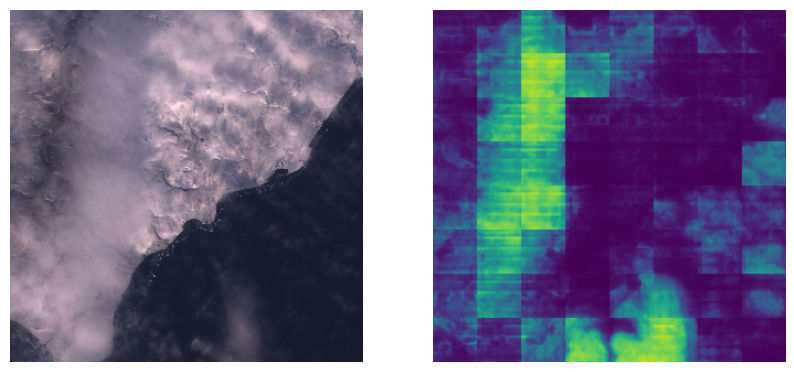

In [34]:
for img_path in imgs[2:3]:
    img = tif2array(img_path)
    img = clip_center(img, 3200, 3200)
    img = img/10000
    img = tf.reshape(img, [1, 3200, 3200, 4])

    patch_size = 400
    stride = 400
    output_shape = (img.shape[1], img.shape[2])

    # Initialize an empty array for storing the full prediction
    full_prediction = np.zeros(output_shape)

    # Iterate over the image with a sliding window
    for i in range(0, img.shape[1], stride):
        for j in range(0, img.shape[2], stride):
            patch = img[:, i:i+patch_size, j:j+patch_size, :]

            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                # Add padding for more continuous full tile prediction
                paddings = tf.constant([[0, 0], [32, 32], [32, 32], [0, 0]])
                pred = u_model(tf.pad(patch, paddings, "SYMMETRIC"), training=False)
                pred = tf.image.resize_with_crop_or_pad(pred, 400, 400)
                pred = tf.nn.softmax(pred, axis=-1)

                # Place the predicted patch back into the full prediction array
                full_prediction[i:i+patch_size, j:j+patch_size] = pred[0, :, :, 1]

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img[0, ::10, ::10, 2::-1], vmin=0, vmax=1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(full_prediction, vmin=0, vmax=1)

    # np.save(img_path[:-7]+'deeplab.npy', full_prediction)